In [ ]:
library(dyno)
library(tidyverse)
library(Matrix)
library(reshape)
library(viridis)
library(reticulate)
library("RColorBrewer")

Paired <- brewer.pal(n =12, name = 'Paired')
Set3 <- brewer.pal(n =12, name = 'Set3')
color <- c(Paired,Set3)

In [2]:
install.packages("devtools")
devtools::install_github("dynverse/dyno")

package 'devtools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cosmic\AppData\Local\Temp\Rtmp46Bd57\downloaded_packages


ERROR: Error in library.dynam(lib, package, package.lib): DLL 'cli' not found: maybe not installed for this architecture?


In [34]:
#devtools::install_github("dynverse/dynplot2@devel")
#library(extrafont)
#font_import()
#loadfonts(device="win")       #Register fonts for Windows bitmap output
#fonts()

In [615]:
# Open pickle file with pandas (à l'aide du package reticulate)
pd <- import("pandas")
Spectra_dataframe <- pd$read_pickle("C:/Users/cosmic/Desktop/Jupyterbooks/Toy_Dataset_25_05_2021_12h.pkl")
Spectra = Matrix(as.matrix(x),sparse=TRUE)
WL_cm <- colnames(Spectra_dataframe)
WL = as.numeric(substr(colnames(Spectra_dataframe),1,nchar(colnames(Spectra_dataframe))-5))

In [616]:
dataset <- wrap_expression(
  counts = Spectra,
  expression = Spectra,
  dimred_acp = dyndimred::dimred_pca(Spectra))

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



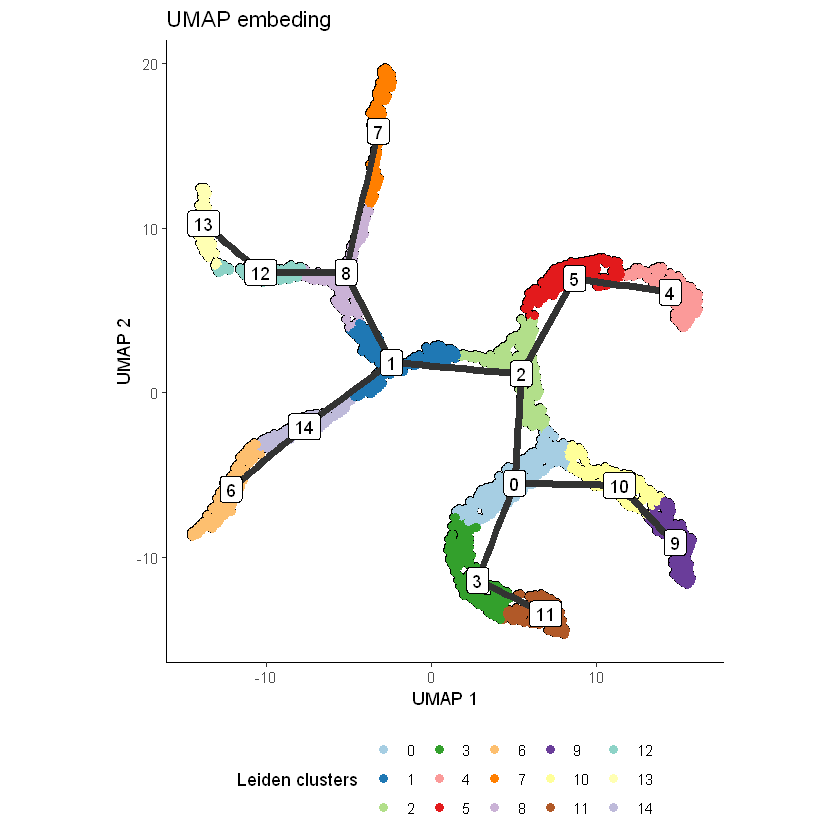

In [617]:
model_paga <- infer_trajectory(
  dataset = dataset,
  method = dynmethods::ti_projected_paga(filter_features = FALSE, 
                                         n_neighbors =15L,
                                         resolution = 0.5L,
                                         embedding_type = "umap"),verbose = FALSE)
plot_dimred(model_paga, grouping = group_onto_nearest_milestones(model_paga),label_milestones=TRUE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

In [631]:
width = 7 
height = 7

a <- plot_dimred(model_paga ,color_milestones = color,plot_trajectory=FALSE, 
                 size_cells = 2 , alpha = 1,
                 grouping = group_onto_nearest_milestones(model_paga),
                 label_milestones=FALSE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters", breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

ggsave(file="UMAP_cluster.svg", plot=a, width=width, height=height, bg = "transparent")
ggsave(file="UMAP_cluster.tiff", plot=a, width=width, height=height, bg = "transparent")

b <- plot_dimred(model_paga,dimred = dataset$dimred_acp, color_milestones = Set3, grouping = group_onto_nearest_milestones(model_paga), label_milestones=FALSE, plot_trajectory = FALSE,
            arrow = grid::arrow(length = grid::unit(0.3, "cm"), type = "closed"), size_milestones = 6, size_transitions = 1)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "PCA",
       x = "PC 1",
       y = "PC 2")+
scale_color_manual(values=color,name = "Leiden clusters", breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

ggsave(file="PCA_cluster.svg", plot=b, width=width, height=height, bg = "transparent")
ggsave(file="PCA_cluster.tiff", plot=b, width=width, height=height, bg = "transparent")

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



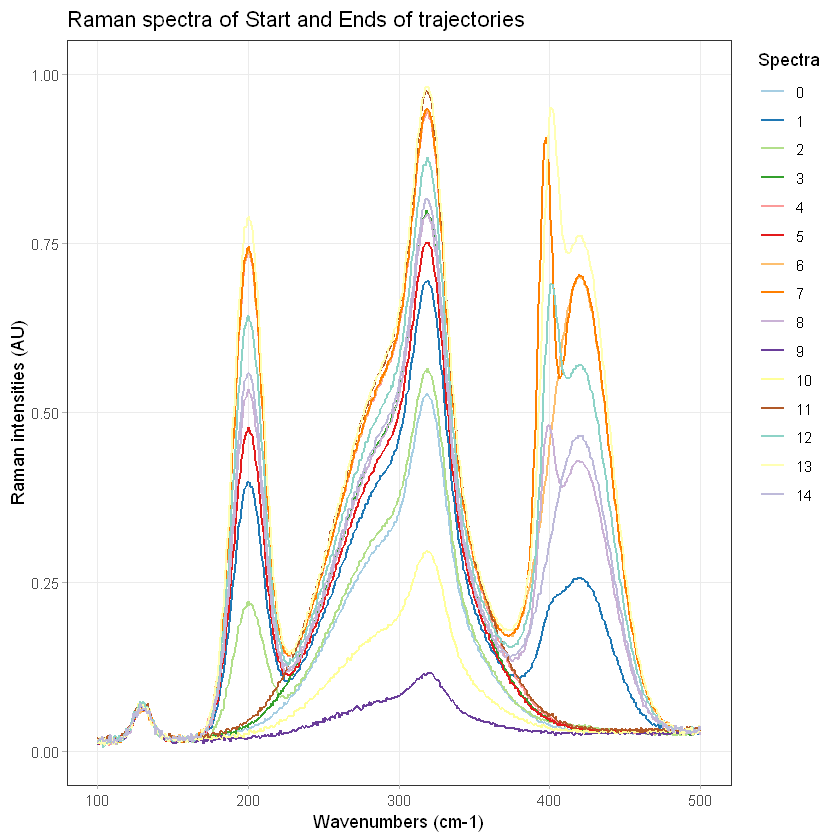

In [644]:
group_id <- data.frame(as.numeric(model_paga$grouping))
colnames(group_id)<-c('Leiden')
colnames(Spectra_dataframe) <- WL
dat <- data_frame(group_id, Spectra_dataframe)
cluster <- aggregate(dat, by=dat[1], FUN=mean)
cluster <- cluster[-2]
cluster2 <- melt(cluster ,  id.vars = 'Leiden')
cluster2$variable <- as.numeric(as.character(cluster2$variable))
cluster2$Leiden <- factor(as.character(cluster2$Leiden), levels = as.character(0:(length(model_paga$group_id)-1)))


c <- ggplot(cluster2, aes(x = variable, y = value))+
    geom_line(aes(color = Leiden), size = 0.8, linetype = "solid") +
    theme_bw()+
    theme(legend.position = "right",
    legend.background = element_rect(fill = "white", size = 4, colour = "white"),
    legend.justification = c(0, 1),
   
    axis.ticks = element_line(colour = "grey70", size = 0.2),

    panel.grid.minor = element_blank()) +
    xlab("Wavenumbers (cm-1)")+
    ylim(0, 1)+
    ylab("Raman intensities (AU)")+
    labs(title = "Raman spectra of Start and Ends of trajectories")+
    scale_color_manual(values=c(color[0:15]),name = "Spectra",
                      breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

ggsave(file="centroides.svg", plot=c, width=width, height=height, bg = "transparent")
ggsave(file="centroides.tiff", plot=c, width=width, height=height, bg = "transparent")

c

In [645]:
model_paga_rooted <- model_paga %>% add_root(root_milestone_id = "9")
model_paga_rooted <- add_pseudotime(model_paga_rooted)
model_paga_rooted <- add_expression(model_paga_rooted, expression = dataset$expression, counts = dataset$expression)

In [647]:
######### 3) PSEUDOTEMPS

pseudo <- plot_dimred(
  model_paga_rooted, 
  expression_source = dataset$expression, 
  color_cells = "pseudotime",
  plot_trajectory = FALSE,
  size_cells = 2)+
theme_classic()+
theme(legend.position = "right")+
labs(title = "Diffusion pseudotime",
       x = "UMAP 1",
       y = "UMAP 2")
scale_colour_gradientn(colours = viridis(100) ,name = "Pseudotime   ")

ggsave(file="pseudotime_UMAP.svg", plot=pseudo, width=width, height=height, bg = "transparent")
ggsave(file="pseudotime_UMAP.tiff", plot=pseudo, width=width, height=height, bg = "transparent")

intensity_UMAP <- patchwork::wrap_plots(
  plot_dimred(model_paga_rooted, feature_oi = c("320.44 cm-1"),size_cells = 2,label_milestones=FALSE, plot_trajectory = FALSE, expression_source = dataset)+ ggtitle("320.4 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("200.2 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("200.2 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "200.2 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("419.84 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("420.6 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "420.6 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("400.6 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("400.6 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "400.6 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("399.8 cm-1"),size_cells = 2, label_milestones=FALSE, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("399.0 cm-1")+ theme(legend.position = "none")+labs(
      title = "399.0 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")
  )+theme_classic()

ggsave(file="intensity_UMAP.svg", plot=intensity_UMAP, width=15, height=15, bg = "transparent")
ggsave(file="intensity_UMAP.tiff", plot=intensity_UMAP, width=15, height=15, bg = "transparent")


intensity_PCA <- patchwork::wrap_plots(
  plot_dimred(model_paga_rooted, feature_oi = c("320.44 cm-1"),label_milestones=FALSE,dimred = dataset$dimred_acp, plot_trajectory = FALSE, expression_source = dataset)+ ggtitle("320.4 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("200.2 cm-1"), label_milestones=FALSE,dimred = dataset$dimred_acp, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("200.2 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("419.84 cm-1"), label_milestones=FALSE,dimred = dataset$dimred_acp, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("420.6 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("400.6 cm-1"), label_milestones=FALSE,dimred = dataset$dimred_acp, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("400.6 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2"),
  plot_dimred(model_paga_rooted, feature_oi = c("399.8 cm-1"), label_milestones=FALSE,dimred = dataset$dimred_acp, plot_trajectory = FALSE,expression_source = dataset)+ ggtitle("399.0 cm-1")+ theme(legend.position = "none")+theme_classic()+labs(
      title = "320.4 cm-1",
       x = "UMAP 1",
       y = "UMAP 2")
)
ggsave(file="intensity_PCA.svg", plot=intensity_PCA, width=20, height=15, bg = "transparent")
ggsave(file="intensity_PCA.tiff", plot=intensity_PCA, width=20, height=15, bg = "transparent")

<ScaleContinuous>
 Range:  
 Limits:    0 --    1

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression

Coloring by expression



In [648]:
# On simplifie les trajectoires
simplified <- simplify_trajectory(model_paga_rooted, allow_self_loops = FALSE)
miles_network<- simplified$milestone_network
miles_network

from,to,length,directed
<chr>,<chr>,<dbl>,<lgl>
0,2,0.13722766,TRUE
2,1,0.08973182,TRUE
1,8,0.15283241,TRUE
8,7,0.12810952,TRUE
0,11,0.50661670,TRUE
2,4,0.37663549,TRUE
9,0,0.71317681,TRUE
8,13,0.75395883,TRUE
1,6,0.65738143,TRUE


Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



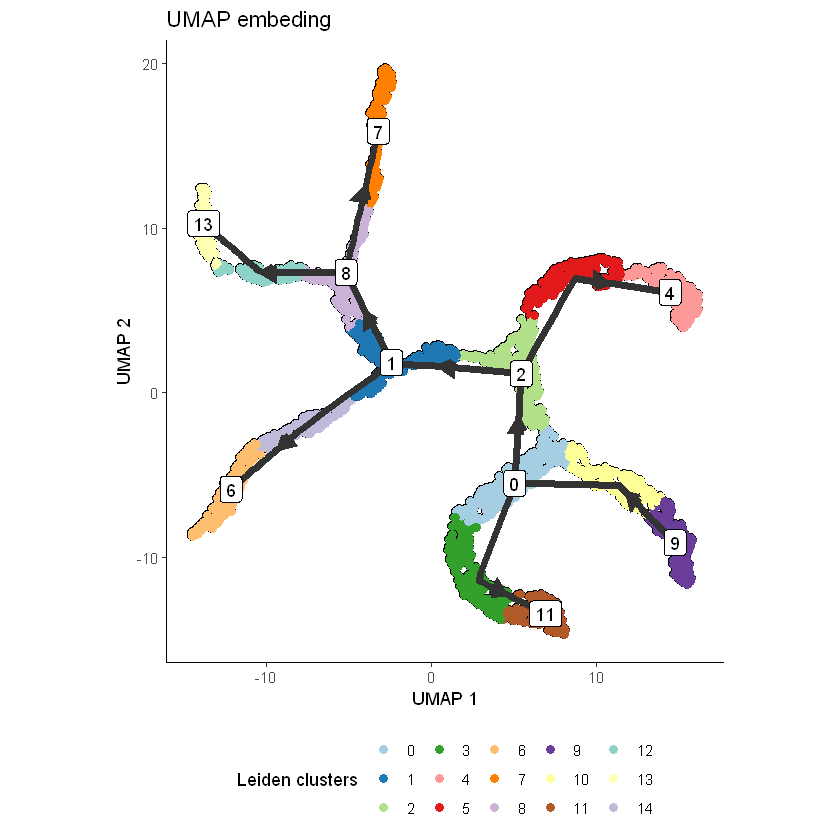

In [649]:
plot_dimred(simplified, grouping = group_onto_nearest_milestones(model_paga),
                , label_milestones=TRUE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

In [650]:
simplified <- simplified %>% label_milestones(c( "0" = "M1",
                                                 "1" = "M3",
                                                 "2" = "M2",
                                                 "4" = "End 2",                                    
                                                 "6" = "End 3",
                                                 "7" = "End 4",
                                                 "8" = "M4",
                                                 "9"= "Start",                                                
                                                 "11"="End 1",
                                                 "13"= "End 5"
                                                                      
                                                           ))

simplified$milestone_network 

from,to,length,directed
<chr>,<chr>,<dbl>,<lgl>
0,2,0.13722766,TRUE
2,1,0.08973182,TRUE
1,8,0.15283241,TRUE
8,7,0.12810952,TRUE
0,11,0.50661670,TRUE
2,4,0.37663549,TRUE
9,0,0.71317681,TRUE
8,13,0.75395883,TRUE
1,6,0.65738143,TRUE


In [769]:
modified_milestone_networks <- bind_rows(miles_network[7,],
                                          miles_network[5,],
                                          miles_network[1,],
                                          miles_network[6,],
                                          miles_network[2,],
                                          miles_network[9,],
                                          miles_network[3,],
                                          miles_network[8,],
                                          miles_network[4,]
                                     )

simplified$milestone_network <- modified_milestone_networks

Coloring by grouping

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



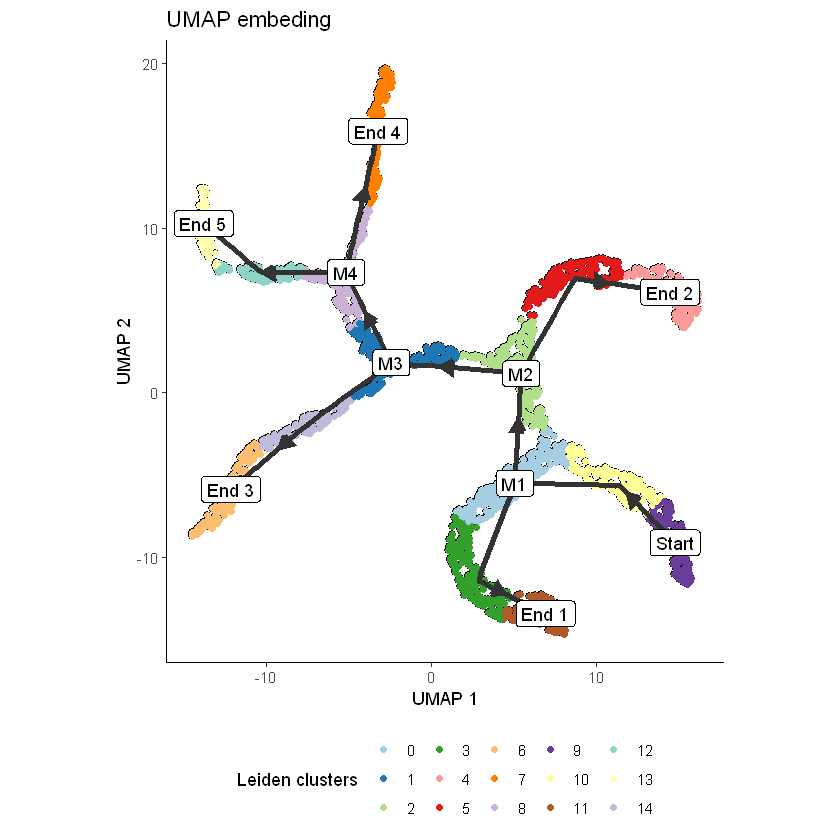

In [652]:
a <-plot_dimred(simplified, grouping = group_onto_nearest_milestones(model_paga_rooted), 
                 border_radius_percentage = .2,
                 arrow = grid::arrow(type = "closed", length = unit(0.1, "inches")),
                 size_cells = 2, label_milestones=TRUE,size_milestones = 5,  size_transitions = 1.5 )+

theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters", breaks = c(as.character(0:(length(model_paga$group_id)-1))))

ggsave(file="simplified.svg", plot=a, width=7, height=7, bg = "transparent")
ggsave(file="simplified.tiff", plot=a, width=7, height=7, bg = "transparent")
a

In [657]:
overall_feature_importances <- dynfeature::calculate_overall_feature_importance(simplified)
features <- overall_feature_importances %>% 
  top_n(20, importance) %>% 
  pull(feature_id)

Coloring by milestone



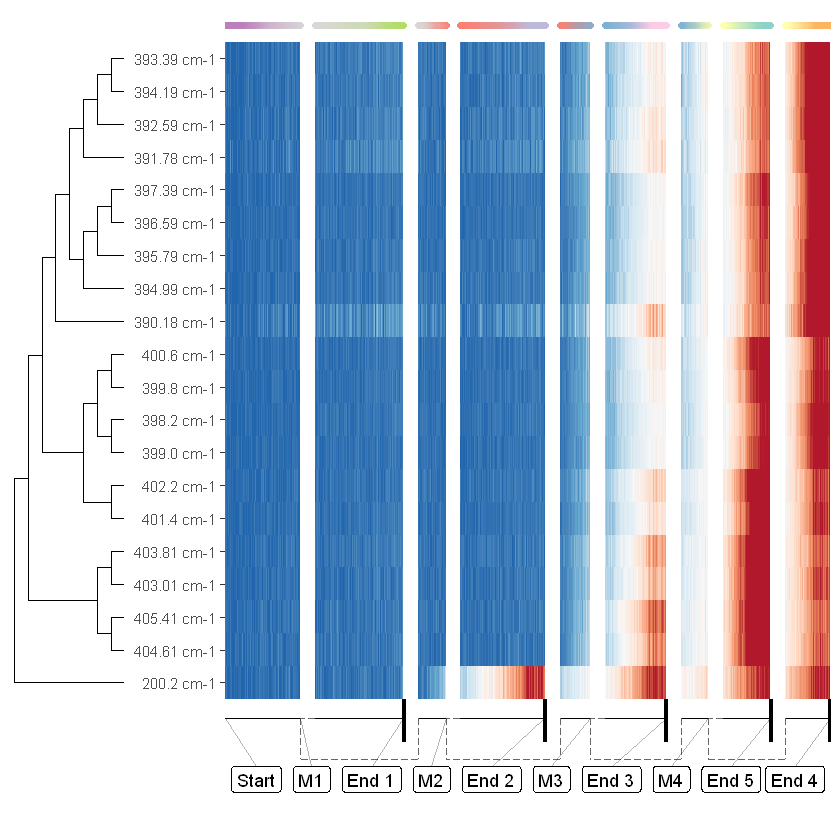

In [676]:
overall_feature_importances <- dynfeature::calculate_overall_feature_importance(simplified)
features <- overall_feature_importances %>% 
  top_n(20, importance) %>% 
  pull(feature_id)

heatmap <- plot_heatmap(simplified,
             expression_source = dataset$expression,                      
             features_oi = features,
             clust = "ward.D2",    
             margin = 0.03,
             scale = dynutils::scale_quantile
             )

ggsave(file="heatmap_20.tiff", plot=heatmap, width=12, height=12, bg = "transparent")
ggsave(file="heatmap_20.svg", plot=heatmap, width=12, height=12, bg = "transparent")
heatmap

Coloring by milestone



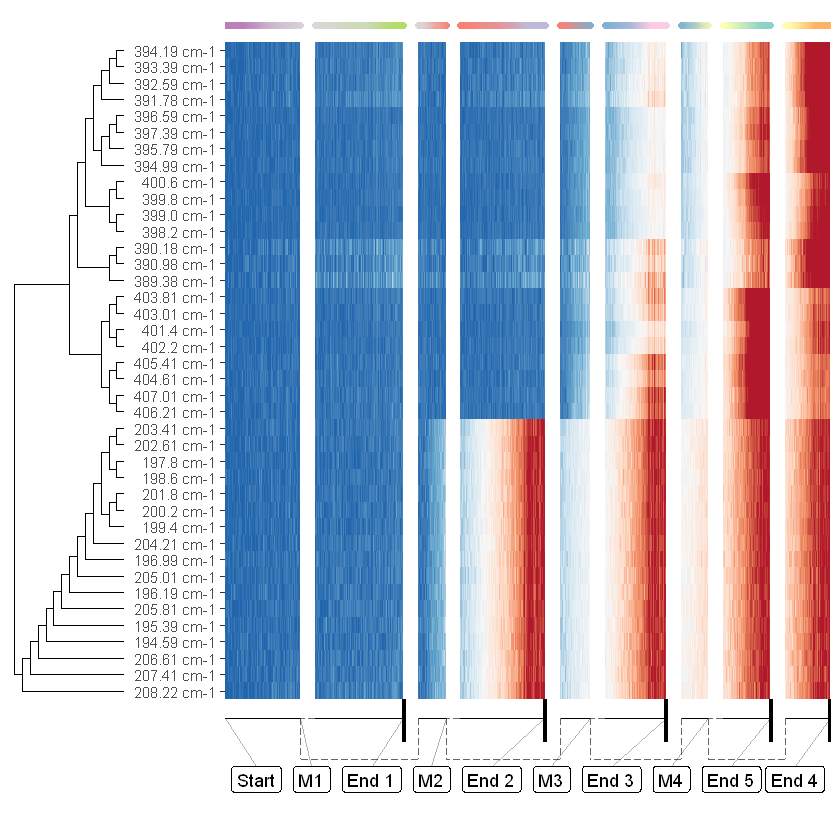

In [677]:
overall_feature_importances <- dynfeature::calculate_overall_feature_importance(simplified)
features <- overall_feature_importances %>% 
  top_n(40, importance) %>% 
  pull(feature_id)

heatmap <- plot_heatmap(simplified,
             expression_source = dataset$expression,                      
             features_oi = features,
             clust = "ward.D2",    
             margin = 0.03,
             scale = dynutils::scale_quantile
             )

ggsave(file="heatmap_40.tiff", plot=heatmap, width=12, height=12, bg = "transparent")
ggsave(file="heatmap_40.svg", plot=heatmap, width=12, height=12, bg = "transparent")
heatmap

Coloring by milestone



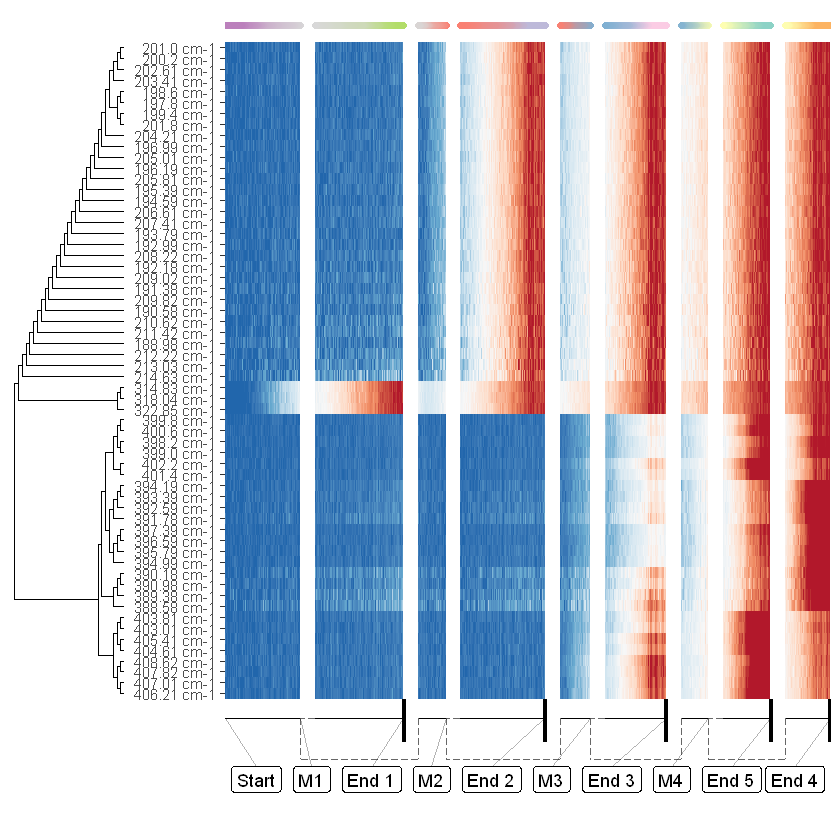

In [678]:
overall_feature_importances <- dynfeature::calculate_overall_feature_importance(simplified)
features <- overall_feature_importances %>% 
  top_n(60, importance) %>% 
  pull(feature_id)

heatmap <- plot_heatmap(simplified,
             expression_source = dataset$expression,                      
             features_oi = features,
             clust = "ward.D2",    
             margin = 0.03,
             scale = dynutils::scale_quantile
             )

ggsave(file="heatmap_60.tiff", plot=heatmap, width=12, height=12, bg = "transparent")
ggsave(file="heatmap_60.svg", plot=heatmap, width=12, height=12, bg = "transparent")
heatmap

In [773]:
features2 = c('130.46 cm-1', '200.2 cm-1','319.64 cm-1', '400.6 cm-1', '399.0 cm-1', '420.64 cm-1')

heatmap <- plot_heatmap(simplified,
             expression_source = dataset$expression,                      
             features_oi = features2,
             clust = "ward.D2",    
             margin = 0.03,
            
             scale = dynutils::scale_quantile
             )+
theme(text = element_text(size = 5))       

#ggsave(file="heatmap_6.tiff", plot=heatmap, width=12, height=12, bg = "transparent")
#ggsave(file="heatmap_6.svg", plot=heatmap, width=12, height=12, bg = "transparent")
heatmap

Coloring by grouping



ERROR: Error in get_grouping(trajectory, grouping): Could not find column pseudotime in cell_info


In [708]:
group <- data.frame(model_paga$grouping)
colnames(group) <- 'leiden'
group$leiden <- as.factor(group$leiden)


In [712]:
sc <- import("scanpy")
ad <- import("anndata")
np <- import("numpy")
plt <- import("matplotlib")
data <- pd$read_pickle("C:/Users/cosmic/Desktop/Jupyterbooks/Toy_Dataset_25_05_2021_12h.pkl")
adata <- sc$AnnData(data, obs = group)

sc$pp$pca(adata, n_comps=as.integer(5), svd_solver='arpack')
sc$pp$neighbors(adata, n_pcs=as.integer(5),  n_neighbors= as.integer(25), metric ='euclidean')
sc$tl$umap(adata)
sc$tl$leiden(adata, resolution = 0.5)
sc$tl$umap(adata)
sc$pl$umap(adata, color='leiden', size = 5)
adata$obs['leiden']<-group

In [714]:
sc$tl$paga(adata)
sc$pl$paga(adata)

In [741]:
adata$uns['leiden_colors']

[1] "#1f77b4" "#ff7f0e" "#279e68" "#d62728" "#aa40fc" "#8c564b" "#e377c2"
 [8] "#b5bd61" "#17becf" "#aec7e8" "#ffbb78" "#98df8a" "#ff9896" "#c5b0d5"
[15] "#c49c94"

In [743]:
str(adata$uns['leiden_colors'])


 chr [1:15] "#1f77b4" "#ff7f0e" "#279e68" "#d62728" "#aa40fc" "#8c564b" ...


In [745]:
str(group)

'data.frame':	2303 obs. of  1 variable:
 $ model_paga.grouping: chr  "10" "11" "10" "3" ...


In [ ]:
sc$tl$umap(adata)
sc$tl$leiden(adata, resolution = 0.5)
sc$tl$umap(adata)
sc$pl$umap(adata, color='leiden', size = 5)
adata$obs['leiden']<-group

In [760]:
adata$uns['leiden_colors']

[1] "#1f77b4" "#ff7f0e" "#279e68" "#d62728" "#aa40fc" "#8c564b" "#e377c2"
 [8] "#b5bd61" "#17becf" "#aec7e8" "#ffbb78" "#98df8a" "#ff9896" "#c5b0d5"
[15] "#c49c94"

In [761]:
color


[1] "#A6CEE3" "#1F78B4" "#B2DF8A" "#33A02C" "#FB9A99" "#E31A1C" "#FDBF6F"
 [8] "#FF7F00" "#CAB2D6" "#6A3D9A" "#FFFF99" "#B15928" "#8DD3C7" "#FFFFB3"
[15] "#BEBADA" "#FB8072" "#80B1D3" "#FDB462" "#B3DE69" "#FCCDE5" "#D9D9D9"
[22] "#BC80BD" "#CCEBC5" "#FFED6F"

In [762]:
adata$uns['leiden_colors'] <- color 

ERROR: Error in adata$uns["leiden_colors"] <- color: objet de type 'environment' non indiçable


In [ ]:
model_paga <- infer_trajectory(
  dataset = dataset,
  method = dynmethods::ti_projected_paga(filter_features = FALSE, 
                                         n_neighbors =15L,
                                         resolution = 0.5L,
                                         embedding_type = "umap"),verbose = FALSE)

a = plot_dimred(model_paga, grouping = group_onto_nearest_milestones(model_paga),
                , label_milestones=TRUE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters",
                  breaks = c("0","1","2","3","4","5","6","7","8","9","10","11","12","13","14"))

ggsave(file="UMAP_init.svg", plot=a, width=7, height=7, bg = "transparent")
ggsave(file="UMAP_init.tiff", plot=a, width=7, height=7, bg = "transparent")


                                                
#row.names(dimred_umap) <- row.names(Spectra)
#colnames(dimred_umap) <- c('UMAP 1', 'UMAP 2')

b <- plot_dimred(model_paga ,color_milestones = color,plot_trajectory=FALSE, 
                 size_cells = 2 , alpha = 1.9,
                 grouping = group_onto_nearest_milestones(model_paga),
                 label_milestones=FALSE)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "UMAP embeding",
       x = "UMAP 1",
       y = "UMAP 2")+
scale_color_manual(values=color,name = "Leiden clusters")

ggsave(file="UMAP.tiff", plot=b, width=7, height=7, bg = "transparent")
ggsave(file="UMAP.svg", plot=b, width=7, height=7, bg = "transparent")

c<-plot_dimred(model_paga,dimred = dataset$dimred_acp, color_milestones = Set3, grouping = group_onto_nearest_milestones(model_paga), label_milestones=FALSE, plot_trajectory = FALSE,
            arrow = grid::arrow(length = grid::unit(0.3, "cm"), type = "closed"), size_milestones = 6, size_transitions = 1)+
theme_classic()+
theme(legend.position = "bottom")+
labs(title = "PCA",
       x = "PC 1",
       y = "PC 2")+
scale_color_manual(values=color,name = "Leiden clusters")

ggsave(file="clustering_ACP.svg", plot=c, width=6, height=6, bg = "transparent")
ggsave(file="clustering_ACP.tiff", plot=c, width=6, height=6, bg = "transparent")

group_id <- data.frame(as.numeric(model_paga$grouping))
colnames(group_id)<-c('Leiden')
dat <- data_frame(group_id, mydata[2:500])
cluster <- aggregate(dat, by=dat[1], FUN=mean)
cluster <- cluster[-2]
cluster2 <- melt(cluster ,  id.vars = 'Leiden', variable.name = 'series')
cluster2$series <- as.numeric(as.character(cluster2$series))
cluster2$Leiden <- factor(as.character(cluster2$Leiden), levels = as.character(0:(length(model_paga$group_id)-1)))
 d <-   ggplot(cluster2, aes(x = series, y = value))+
    geom_line(aes(color = Leiden), size = 0.8, linetype = "solid") +
    theme(legend.position = "right", text=element_text(family="Arial", size=10)) +
   
    xlab("Wavenumbers (cm-1)")+
    ylim(0, 1)+
    ylab("Raman intensities (AU)")+
    labs(title = "Raman spectra of Start and Ends of trajectories")+
    scale_color_manual(values=c(color[0:15]),name = "Spectra")

ggsave(file="centro.svg", plot=d, width=6, height=6, bg = "transparent")
ggsave(file="centro.tiff", plot=d, width=10, height=5, bg = "transparent")